# Homework 4
Group: 31  
Members: Linus Kleine Kruthaup, Isabel Grauwelman, Mara Rehmer  
Week 3

In [69]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 1 Data set

The Malaria dataset we use in this homework contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. Before we can feed it into our network we need to perform some preprocessing

In [70]:
# We load our dataset and split it into train (80%) and test (20%) data. We also
# shuffle our dataset and specify that we also require the target labels of the
# images with the parameter as_supervised = True
(train_dataset, test_dataset) = tfds.load('malaria', as_supervised=True, shuffle_files=True, split = (['train[:80%]', 'train[80%:]']))

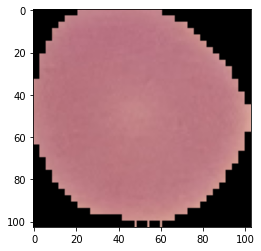

Image label:  uninfected
Image shape:  (103, 103, 3)


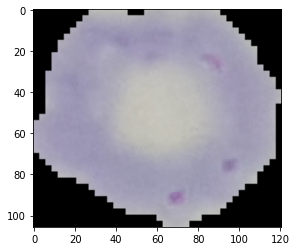

Image label:  uninfected
Image shape:  (106, 121, 3)


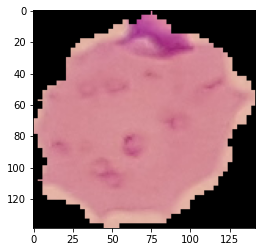

Image label:  parasitized
Image shape:  (139, 142, 3)


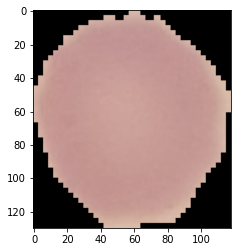

Image label:  uninfected
Image shape:  (130, 118, 3)


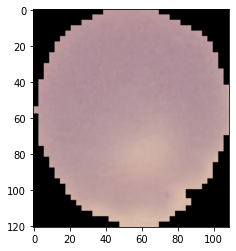

Image label:  uninfected
Image shape:  (121, 109, 3)


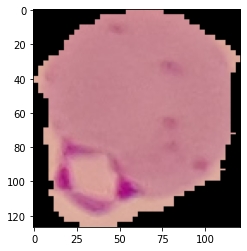

Image label:  parasitized
Image shape:  (127, 121, 3)


In [71]:
# We visualize some images, the corresponding label and the shape of the image.
# the method take allows us to obtain n elements of the dataset
for image, label in train_dataset.take(6):
  plt.figure()
  plt.imshow(image) 
  plt.show() 
  if label.numpy() == 0:
    classification = 'parasitized'
  else:
    classification = 'uninfected'
  print('Image label: ', classification)
  print('Image shape: ', image.numpy().shape)

One can see that the displayed images all have different shapes. In order to feed them into the CNN we need them to be of equal size.

In [72]:
# Resizing all images of the dataset to be 128 x 128. If the target dimensions don't match the image dimensions, the image is resized and then padded with zeroes to match requested dimensions.
train_dataset = train_dataset.map(lambda image, label: (tf.image.resize_with_pad(image,128,128),label))
test_dataset = test_dataset.map(lambda image, label: (tf.image.resize_with_pad(image,128,128),label))

In [73]:
# Linearly scaling each image to have mean 0 and variance 1.
train_dataset = train_dataset.map(lambda image, label: (tf.image.per_image_standardization(image), label))
test_dataset = test_dataset.map(lambda image, label: (tf.image.per_image_standardization(image), label))

In [74]:
# One hot encoding the labels.
train_dataset = train_dataset.map(lambda image, label: (image, tf.one_hot(int(label),1)))
test_dataset = test_dataset.map(lambda image, label: (image, tf.one_hot(int(label),1)))

In [75]:
train_dataset = train_dataset.batch(64).prefetch(50)
test_dataset = test_dataset.batch(64).prefetch(50)

## 2 Model

In [76]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # 4 layers of Convolution layers and MaxPool layers 
        self.conv_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                               activation=tf.keras.activations.relu, input_shape = (128,128,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 5,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 5,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 7,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_4 = tf.keras.layers.MaxPool2D()
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_layer = tf.keras.layers.Dense(32, activation = tf.keras.activations.relu)

        self.output_layer = tf.keras.layers.Dense(1,
                                                  activation = tf.keras.activations.sigmoid
                                                  )

    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.max_pool_4(x)
        x = self.global_pool(x)
        x = self.dense_layer(x)
        x = self.output_layer(x)

        return x

## 3 Training

In [77]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        # If the prediction is off from the the target by < 0.5 the image is classified correctly
        sample_test_accuracy = np.mean(abs(target - prediction) < 0.5)
        
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, binary_crossentropy)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, binary_crossentropy)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, binary_crossentropy, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, binary_crossentropy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



## 4 Visualization


In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()